**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 17 de octubre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación en Image Colorization

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de Image Colorization. En particular pasar de imágenes en escala de grises a imágenes a color.
1. Como dataset puede utilizar ImageWoof (https://docs.ultralytics.com/es/datasets/classify/imagewoof/#dataset-variants)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Puede usar una biblioteca como OpenCV para obtener las imágenes en escala de grises, o incluso pasar las imágenes iniciales de RGB al espacio de color CIE LAB (el canal L le servirá).
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import seaborn as sns
import wandb
import cv2
import tensorflow_io as tfio
from collections import defaultdict

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization


### • Define global size for all our images, we will use this dimensions across our project, it also helps to reduce the resources needed to run the project and unifies the size of all images since in this dataset the images size is not unified

In [2]:
images_dimensions = (160, 160)

## • Load Dataset

In [3]:
# Load the training dataset
print("Loading train dataset in progess....")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/train',
    batch_size=64,  # Batch size
    image_size = images_dimensions,  # Resize images to the required input size for your model
)

print("Loading train dataset completed!!!")

# Load the test dataset
print("Loading test dataset in progess....")

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/val',
    batch_size=64,  # Batch size
    image_size = images_dimensions,  # Resize images to the required input size for your model
)

print("Loading test dataset completed!!!")


Loading train dataset in progess....
Found 9025 files belonging to 10 classes.
Loading train dataset completed!!!
Loading test dataset in progess....
Found 3929 files belonging to 10 classes.
Loading test dataset completed!!!


## • Visualize a few images from training to see they are loading correctly

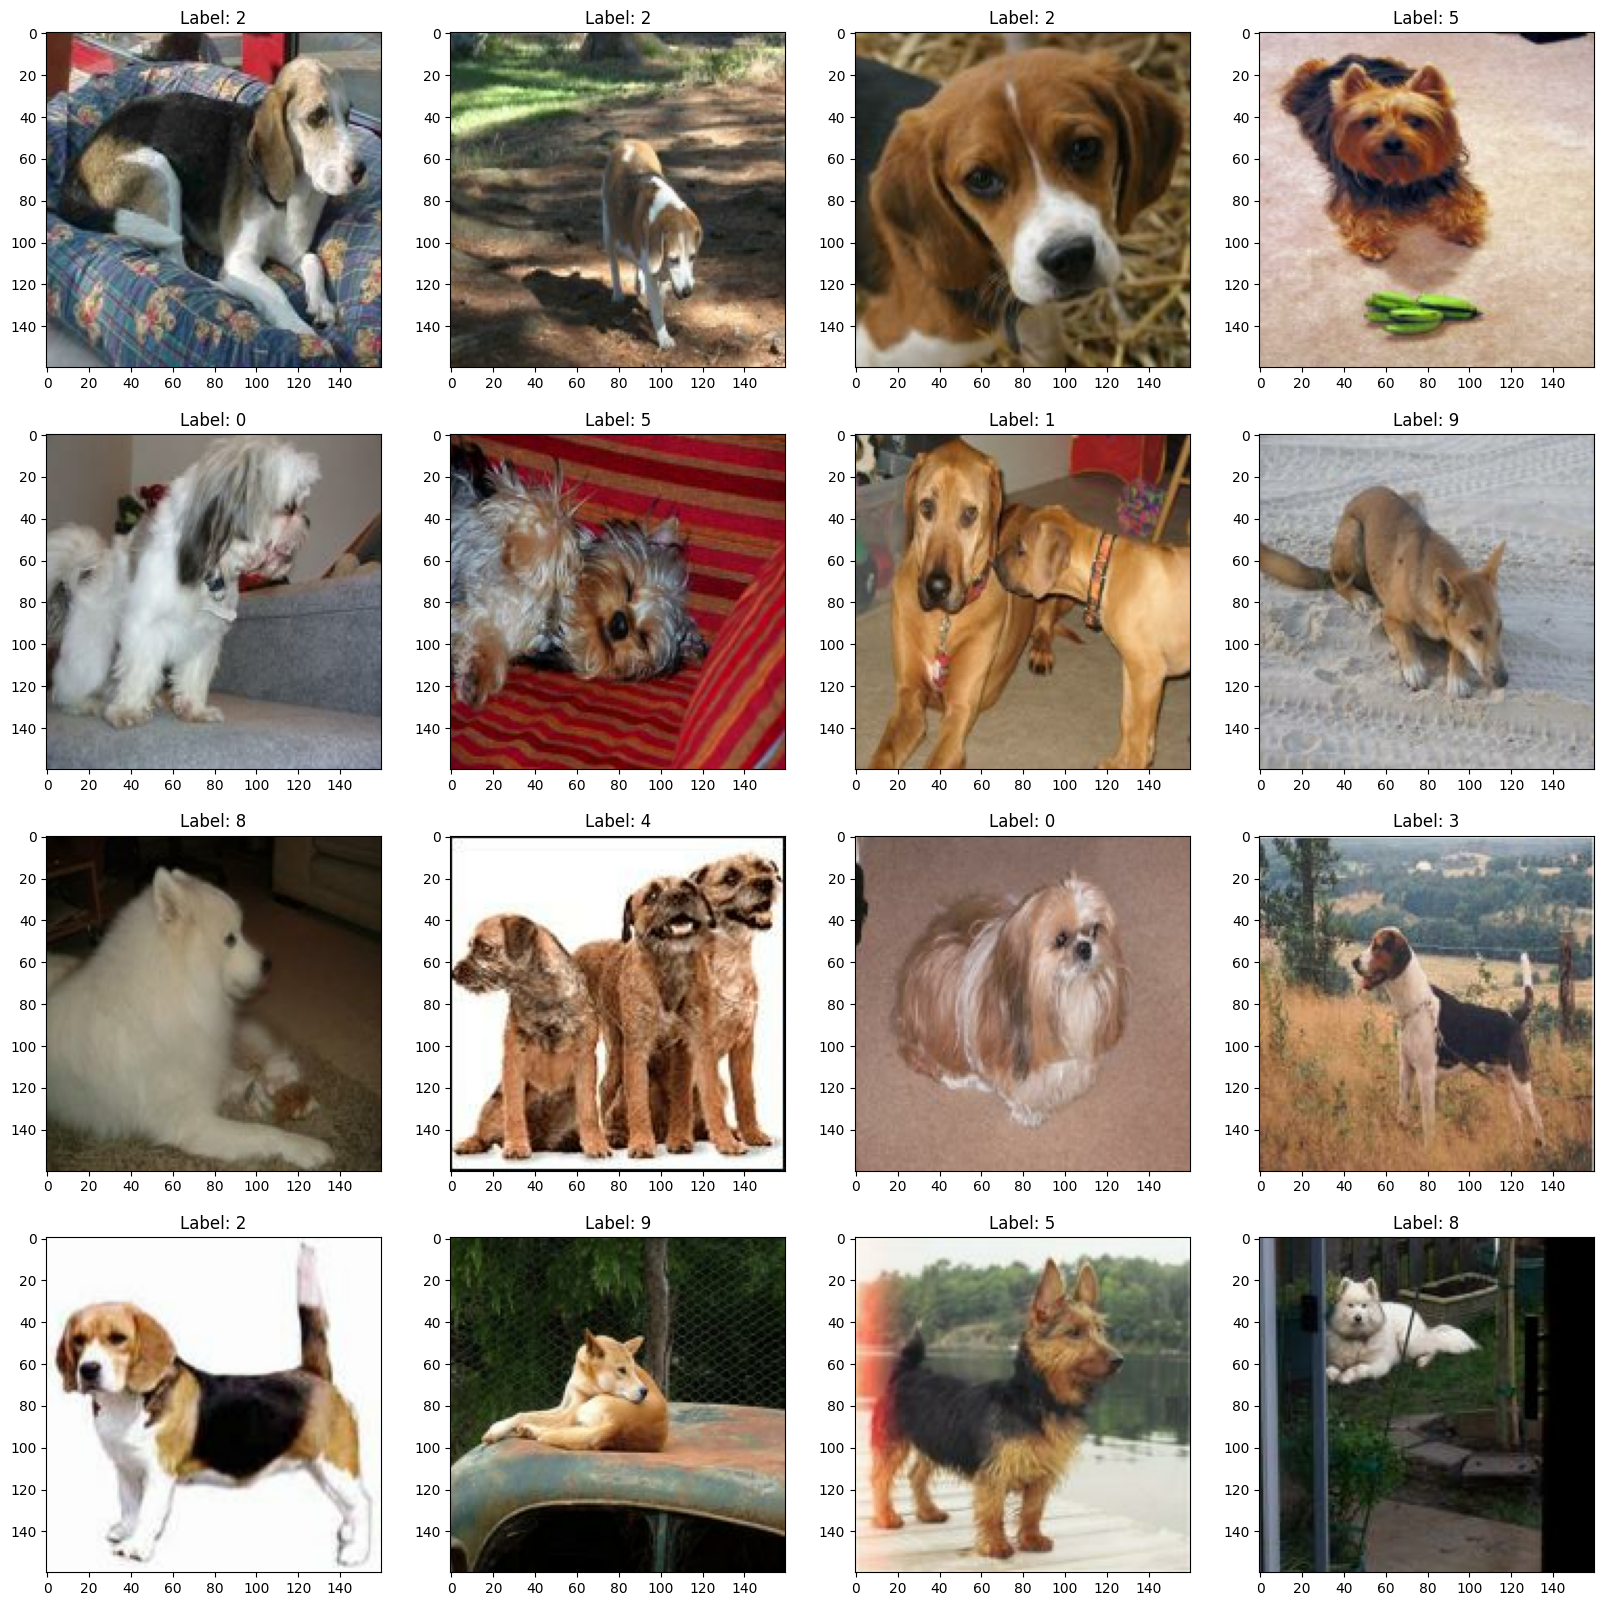

In [4]:
def visualize_images_lot(images, labels, lot_size = 16, rows = 4, cols= 4, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    for i in range(lot_size): 
        ax = plt.subplot(rows, cols, i + 1)  # Create a rowsxcols grid for displaying images
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy and display
        plt.title(f"Label: {labels[i].numpy()}")  # Show the label    
    plt.show()  # Display the images

# Get the first batch
for first_images, first_labels in train_dataset.take(1):
    break
    
visualize_images_lot(first_images, first_labels)

## • Now we will convert our training dataset to the LAB color space, this is because we wiil use the grayscale channel (L) as input and the AB channels as our lables to predict, so our model needs to learn to generate AB channels (a 2D matrix) from one channel

In [5]:
# Convert RGB image to Lab color space
def rgb_to_lab(image, label):
    normalized_image = image / 255.0
    lab_img = tfio.experimental.color.rgb_to_lab(normalized_image)
    return lab_img, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(rgb_to_lab)

## • Now we can plot a few images of our training dataset to the LAB color space to visualize the transformation is working

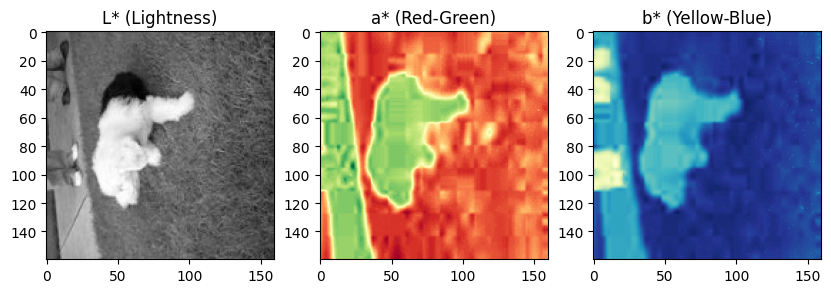

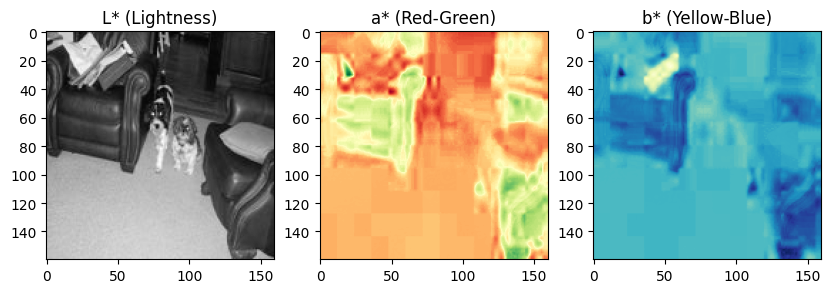

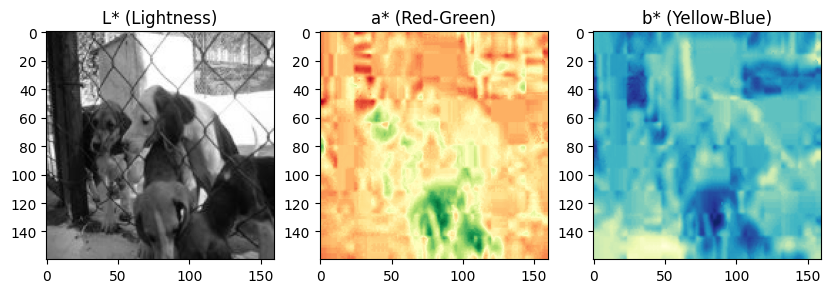

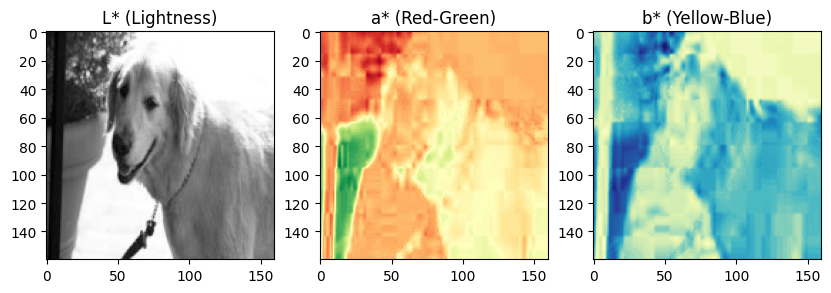

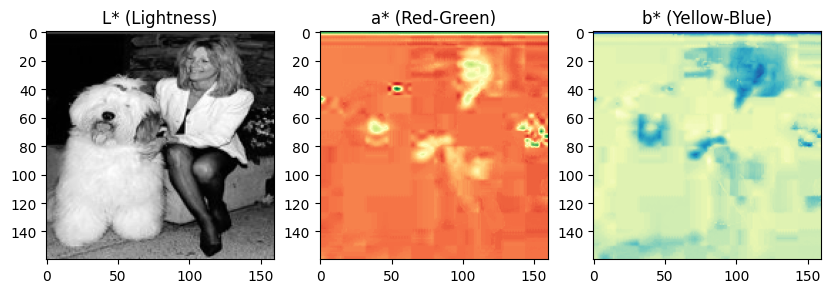

In [6]:
def visualize_images_LAB(images, labels, lot_size = 5, rows = 1, cols= 3, figsize = (10, 10)):
    for i in range(lot_size):
        fig, axs = plt.subplots(rows, cols, figsize = figsize)
        image_lab = images[i]
        axs[0].imshow(image_lab[:, :, 0], cmap='gray')
        axs[0].set_title('L* (Lightness)')

        axs[1].imshow(image_lab[:, :, 1], cmap='RdYlGn')
        axs[1].set_title('a* (Red-Green)')

        axs[2].imshow(image_lab[:, :, 2], cmap='YlGnBu')
        axs[2].set_title('b* (Yellow-Blue)')
    
    plt.show()

# Get the first batch
for first_images_lab, first_labels_lab in train_dataset.take(1):
    break
    
visualize_images_LAB(first_images_lab, first_labels_lab)

## • Data normalization

### Note that the grayscale channel (L) normalizes different than the AB channels

In [7]:
# Normalize the data
def normalize_data(image, label):    

     # Split the image into its 3 channels (maintaining the (160, 160) dimensions)
    channel_1 = image[:, :, :, 0]  # First channel (R) - keep the shape (160, 160, 1)
    channel_2 = image[:, :, :, 1]  # Second channel (G) - keep the shape (160, 160, 1)
    channel_3 = image[:, :, :, 2]  # Third channel (B) - keep the shape (160, 160, 1)

    # Apply the operations
    channel_1 = channel_1 / 255.0  # Example multiplication on first channel
    channel_2 = channel_2 / 128.0  # Example subtraction on second channel
    channel_3 = channel_3 / 128.0  # Example subtraction on third channel

    # Reconstruct the image by concatenating the processed channels back together
    normalized_image = tf.stack([channel_1, channel_2, channel_3], axis=-1)
    
    return normalized_image, label

tf.Tensor(
[[[ 0.06761168 -0.02602185  0.05370332]
  [ 0.07174856 -0.02588204  0.05328483]
  [ 0.09902999 -0.02502045  0.05086623]
  ...
  [ 0.07681384 -0.04488719  0.06319657]
  [ 0.09334548 -0.04387449  0.06142747]
  [ 0.10384136 -0.04327879  0.06041816]]

 [[ 0.08977626 -0.02530089  0.05162689]
  [ 0.06945422 -0.02595934  0.05351501]
  [ 0.07266361 -0.02585154  0.05319435]
  ...
  [ 0.080427   -0.04465773  0.06278921]
  [ 0.08980869 -0.04408322  0.06178636]
  [ 0.09378617 -0.04384864  0.06138343]]

 [[ 0.10599314 -0.02481742  0.05032839]
  [ 0.07266361 -0.02585154  0.05319435]
  [ 0.05357805 -0.02651149  0.05524911]
  ...
  [ 0.08625174 -0.04429743  0.06215759]
  [ 0.0844655  -0.04440662  0.06234809]
  [ 0.080427   -0.04465773  0.06278921]]

 ...

 [[ 0.08380555 -0.07661304  0.12150858]
  [ 0.09176584 -0.07609965  0.12010657]
  [ 0.18797891 -0.07007667  0.10679169]
  ...
  [ 0.16006525 -0.04677498  0.09839772]
  [ 0.09457891 -0.04901888  0.10708287]
  [ 0.079925   -0.04944822  0.109

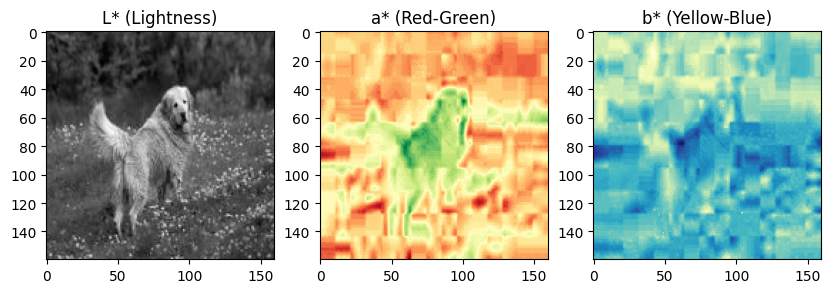

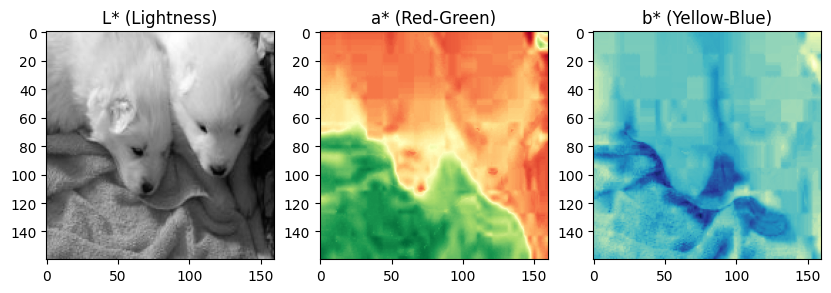

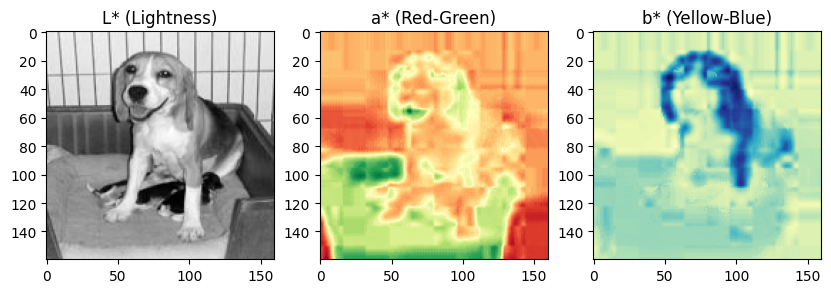

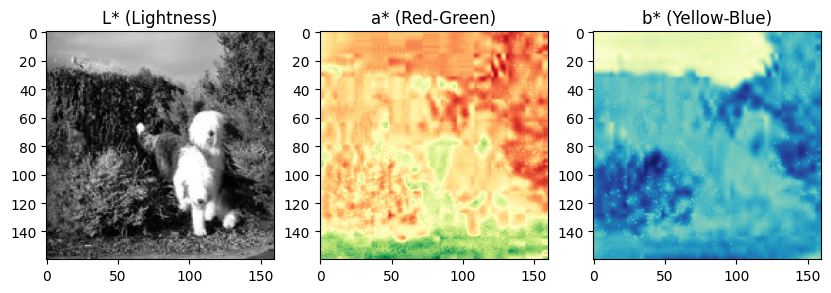

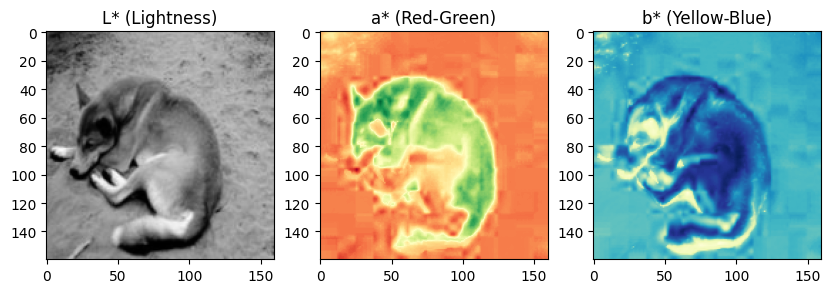

In [8]:
# Normalize the dataset
train_dataset = train_dataset.map(normalize_data)

for first_images_lab_normalized, first_labels_lab_normalized in train_dataset.take(1):
    print(first_images_lab_normalized[0])
    break
    
visualize_images_LAB(first_images_lab_normalized, first_labels_lab_normalized)

### Lets build and split dataset

In [9]:
# Split the data, X will be the grayscale channel and AB will be the objective to predict
def split_LAB_images_data(image, label):    

     # Split the image into its 3 channels (maintaining the (160, 160) dimensions)
    channel_1 = image[:, :, :, 0]  # First channel (R) - keep the shape (160, 160, 1)
    channel_2 = image[:, :, :, 1]  # Second channel (G) - keep the shape (160, 160, 1)
    channel_3 = image[:, :, :, 2]  # Third channel (B) - keep the shape (160, 160, 1)

    # Reconstruct the image by concatenating the processed channels back together
    grayscale_image = channel_1
    ab_channels_image = tf.stack([channel_2, channel_3], axis=-1)

    print(grayscale_image.shape)
    print(ab_channels_image.shape)
    
    return grayscale_image, ab_channels_image

train_dataset = train_dataset.map(split_LAB_images_data)


(None, 160, 160)
(None, 160, 160, 2)


In [10]:
train_dataset = train_dataset.unbatch()
X_grayscale_images = np.asarray(list(train_dataset.map(lambda x, y: x)))
Y_AB_images = np.asarray(list(train_dataset.map(lambda x, y: y)))

print("Shape of train images - grayscale", X_grayscale_images.shape)
print("Shape of train images - AB channels", Y_AB_images.shape)

Shape of train images - grayscale (9025, 160, 160)
Shape of train images - AB channels (9025, 160, 160, 2)


In [11]:
# Define the CNN model
def create_colorization_model(input_shape=(160, 160, 1)):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))  # Fewer filters
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Bottleneck
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))  # Smaller bottleneck

    # Decoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))  # Output 2 channels (AB)

    return model

In [12]:
# Training the model
def train_model(model, X_train, y_train, batch_size=64, epochs=20, checkpoint_dir='checkpoints_epochs_new_test'):
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'Precision'])

    # Create checkpoints
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'colorization_model.h5'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_cb])
    return history

In [13]:
model = create_colorization_model(input_shape=(160, 160, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        7

In [14]:
#model = create_colorization_model(input_shape=(160, 160, 1))
history = train_model(model, X_grayscale_images, Y_AB_images, batch_size=64, epochs=3)

Epoch 1/3
113/113 [==============================] - 180s 2s/step - loss: 0.0100 - accuracy: 0.7802 - precision: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.7811 - val_precision: 0.0000e+00
Epoch 2/3
113/113 [==============================] - 197s 2s/step - loss: 0.0099 - accuracy: 0.7862 - precision: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.7811 - val_precision: 0.0000e+00
Epoch 3/3
113/113 [==============================] - 190s 2s/step - loss: 0.0099 - accuracy: 0.7862 - precision: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.7811 - val_precision: 0.0000e+00


### • First we load our model if we have one saved

In [14]:
# Load the trained model
#model = tf.keras.models.load_model('checkpoints_epochs5/colorization_model.h5')

### • Now we generate a copy from the test set but in lab format

In [15]:
# Apply the preprocessing function to the dataset
val_dataset_lab = test_dataset.map(rgb_to_lab)

val_dataset_lab = val_dataset_lab.unbatch()
val_dataset_lab_images = np.asarray(list(val_dataset_lab.map(lambda x, y: x)))
val_dataset_lab_labels = np.asarray(list(val_dataset_lab.map(lambda x, y: y)))

print("Shape of val LAB images", val_dataset_lab_images.shape)

Shape of val LAB images (3929, 160, 160, 3)


### • Now we split from Grayscale (L channel) and A,B channels

In [16]:
#Images only with grayscale channel
test_images_grayscale = val_dataset_lab_images[:, :, :, 0] / 255.0
test_images_grayscale = test_images_grayscale.reshape(test_images_grayscale.shape[0], test_images_grayscale.shape[1], test_images_grayscale.shape[2])
print(test_images_grayscale[0].shape)
print(test_images_grayscale[0])

#Images with AB channels
test_images_AB = val_dataset_lab_images[:, :, :, 1:] / 128.0
print(test_images_AB[0].shape)
print(test_images_AB[0])

(160, 160)
[[0.0448171  0.04835331 0.05376394 ... 0.04704081 0.05123703 0.0702329 ]
 [0.05492983 0.05588157 0.05777943 ... 0.06643648 0.05325462 0.04969432]
 [0.06329561 0.06175133 0.06020233 ... 0.04681247 0.03464195 0.05912755]
 ...
 [0.08521516 0.08377157 0.08271742 ... 0.03211303 0.03303184 0.03303184]
 [0.08521516 0.08521516 0.08416853 ... 0.03311598 0.03303184 0.03202754]
 [0.0866671  0.08521516 0.08416853 ... 0.03410403 0.03136474 0.02940009]]
(160, 160, 2)
[[[ 0.03229897 -0.03030582]
  [ 0.03203645 -0.03008372]
  [ 0.03165402 -0.02975836]
  ...
  [ 0.03654562  0.01990371]
  [ 0.03890926 -0.00308785]
  [ 0.04087668 -0.01328513]]

 [[ 0.03058056 -0.02712496]
  [ 0.03051862 -0.0270749 ]
  [ 0.0303972  -0.02697636]
  ...
  [ 0.03481773  0.018813  ]
  [ 0.03702287  0.00211867]
  [ 0.04082185 -0.00839303]]

 [[ 0.02907822 -0.02414039]
  [ 0.02916821 -0.02420903]
  [ 0.02925994 -0.02427883]
  ...
  [ 0.03529148  0.02436186]
  [ 0.03705657  0.00804584]
  [ 0.03824604 -0.00312831]]

 ..

### • Now we predict the AB channels from a grayscale image

In [17]:
ab_channels = model.predict(test_images_grayscale[0].reshape(1 , test_images_grayscale[0].shape[0], test_images_grayscale[0].shape[1], 1))
print(ab_channels)
ab_channels = ab_channels[0] * 128.0
print(ab_channels.shape)
print(ab_channels)

1/1 [==============================] - 0s 181ms/step
[[[[-2.06220942e-03  4.57453839e-02]
   [-8.29516072e-03  5.23586161e-02]
   [-7.44785788e-03  5.29822819e-02]
   ...
   [-5.42900013e-03  6.16139844e-02]
   [-4.68658563e-03  6.20821230e-02]
   [-5.64978598e-03  4.87789139e-02]]

  [[-1.07139386e-02  5.91640808e-02]
   [-1.52903823e-02  6.60300776e-02]
   [-1.35544064e-02  6.45939037e-02]
   ...
   [-9.64761991e-03  6.62081093e-02]
   [-1.14232646e-02  6.68285489e-02]
   [-9.15066898e-03  5.93487024e-02]]

  [[-8.14089924e-03  6.15033843e-02]
   [-1.42391967e-02  6.61113784e-02]
   [-1.17826834e-02  6.43780753e-02]
   ...
   [-1.07114827e-02  6.64281622e-02]
   [-1.28251435e-02  6.82960898e-02]
   [-1.01765729e-02  5.84653579e-02]]

  ...

  [[-5.41672111e-03  7.05558360e-02]
   [-8.90374929e-03  8.06784779e-02]
   [-7.76897138e-03  7.94430226e-02]
   ...
   [-1.16016166e-02  7.57966563e-02]
   [-1.16104186e-02  7.49020353e-02]
   [-1.20230950e-02  6.20790422e-02]]

  [[-5.19202929e

### Predicted channels

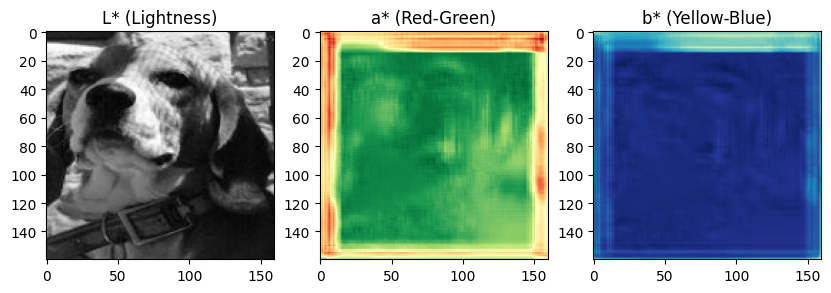

In [18]:

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
axs[0].imshow(test_images_grayscale[0], cmap='gray')
axs[0].set_title('L* (Lightness)')

axs[1].imshow(ab_channels[:, :, 0], cmap='RdYlGn')
axs[1].set_title('a* (Red-Green)')

axs[2].imshow(ab_channels[:, :, 1], cmap='YlGnBu')
axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()

### • Expected Channels

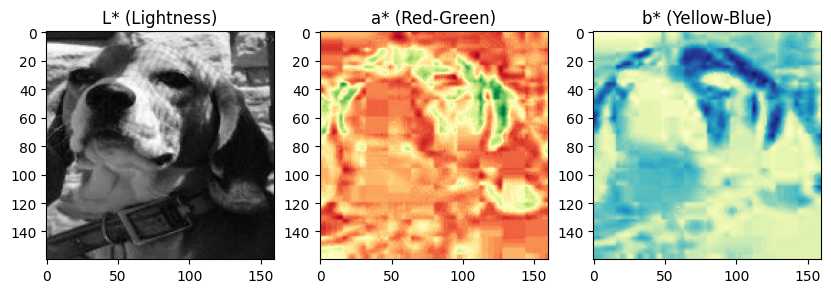

In [19]:
first_test_image_lab = val_dataset_lab_images[0]

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
axs[0].imshow(first_test_image_lab[:, :, 0], cmap='gray')
axs[0].set_title('L* (Lightness)')

axs[1].imshow(first_test_image_lab[:, :, 1], cmap='RdYlGn')
axs[1].set_title('a* (Red-Green)')

axs[2].imshow(first_test_image_lab[:, :, 2], cmap='YlGnBu')
axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()

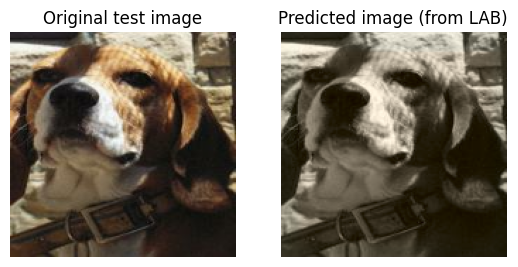

In [20]:
# Convert LAB to RGB
def lab_to_rgb(lab_img):
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    return rgb_img


#print(val_dataset_lab_images[0] == first_test_image_lab)

original_test_image_rgb = lab_to_rgb(first_test_image_lab)

# Plotting the RGB image converted from LAB
plt.subplot(1, 2, 1)

plt.imshow(cv2.cvtColor(original_test_image_rgb, cv2.COLOR_BGR2RGB))
plt.title("Original test image")
plt.axis('off')

plt.subplot(1, 2, 2)

first_test_image_lab[:, :, 1:] = ab_channels  # Replace AB channels in the original LAB image

predicted_image_rgb = lab_to_rgb(first_test_image_lab)

plt.imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
plt.title("Predicted image (from LAB)")
plt.axis('off')





# Show the plots
#plt.tight_layout()
plt.show()